## Filtering 

**20191206**

Used John Puritz's SNP filtering [tutorial](http://www.ddocent.com/filtering/) for guidance.

Filtetered loci for the following things:
- no indels or complex variants
- up to 30% missing data per locus
- minimum minor allele frequency of 5%
- minimum minor allele count of 5 reads
- minimum quality score of 20

Retained indivduals with a maximum of 30% missing data (all).

Filtered for one SNP per RAD tag and removed SNPs if out of HWE.



In [10]:
import matplotlib.pyplot as plt
import numpy as np

### **[1]** Remove indels

In [2]:
!vcftools --vcf TotalRawSNPs_CGmox.vcf \
--remove-indels --recode --recode-INFO-all \
--out TotalRawSNPs_CGmox_noINDL


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf TotalRawSNPs_CGmox.vcf
	--recode-INFO-all
	--out TotalRawSNPs_CGmox_noINDL
	--recode
	--remove-indels

After filtering, kept 290 out of 290 Individuals
Outputting VCF file...
After filtering, kept 480812 out of a possible 585186 Sites
Run Time = 594.00 seconds


### **[2]** Primitive SNPs only

Ran in the command line separately, also didn't remove any SNPs!

``!vcfallelicprimitives \
TotalRawSNPs_CGmox_noINDL.recode.vcf \
--keep-info \
--keep-geno > primSNPs_CGmox_noINDL.vcf``

In [4]:
!ls *vcf

primSNPs_CGmox_noINDL.vcf	      TotalRawSNPs_CGmox.vcf
TotalRawSNPs_CGmox_noINDL.recode.vcf


### **[3]** First pass within individual filtering


In [5]:
!vcftools --vcf primSNPs_CGmox_noINDL.vcf \
--mac 5 \
--minQ 20 \
--minDP 10 \
--recode --recode-INFO-all \
--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL.vcf
	--recode-INFO-all
	--mac 5
	--minDP 10
	--minQ 20
	--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10
	--recode

After filtering, kept 290 out of 290 Individuals
Outputting VCF file...
After filtering, kept 87041 out of a possible 480812 Sites
Run Time = 151.00 seconds


### **[4]** Plot missing data per ind and remove bad individuals

In [8]:
!vcftools --vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10.recode.vcf --missing-indv


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10.recode.vcf
	--missing-indv

After filtering, kept 290 out of 290 Individuals
Outputting Individual Missingness
After filtering, kept 87041 out of a possible 87041 Sites
Run Time = 12.00 seconds


In [9]:
!head out.imiss

INDV	N_DATA	N_GENOTYPES_FILTERED	N_MISS	F_MISS
CatalinaCA_366	87041	0	19030	0.218633
CatalinaCA_367	87041	0	22166	0.254662
CatalinaCA_370	87041	0	23689	0.272159
CatalinaCA_371	87041	0	23814	0.273595
CatalinaCA_372	87041	0	22164	0.254639
CatalinaCA_373	87041	0	24170	0.277685
CatalinaCA_374	87041	0	22096	0.253857
CatalinaCA_375	87041	0	23137	0.265817
CatalinaCA_376	87041	0	22694	0.260728


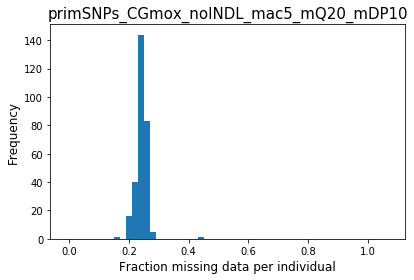

In [12]:
ind_md_file = open("out.imiss", "r")
ind_md_dict = {}
for line in ind_md_file:
    if line.startswith("INDV") == False:
        linelist = line.strip().split()
        ind = linelist[0]
        md = float(linelist[4])
        ind_md_dict[ind] = md
ind_md_file.close()

plt.hist(ind_md_dict.values(), bins=np.arange(0,1.1,0.02) - 0.01)
plt.title("primSNPs_CGmox_noINDL_mac5_mQ20_mDP10", size = 15)
plt.xlabel("Fraction missing data per individual", size=12)
plt.ylabel("Frequency", size = 12)
plt.tight_layout()
plt.show()
#plt.savefig("md_per_ind_hist_primSNPs_CGmox_noINDL_mac5_mQ20_mDP10.png", dpi=300)

In [14]:
print(np.min(list(ind_md_dict.values())))
print(np.max(list(ind_md_dict.values())))
print(np.mean(list(ind_md_dict.values())))

0.154364
0.449237
0.24108154827586203


In [19]:
above_count = 0 
below_count = 0
threshold = 0.3
for ind in ind_md_dict:
    if ind_md_dict[ind] < threshold:
        above_count += 1
    else:
        below_count += 1
        print("Ind to remove:", ind)
print("Num inds make threshold", above_count)
print("Num don't", below_count)


Ind to remove: CatalinaCA_Q353
Num inds make threshold 289
Num don't 1


In [21]:
!vcftools --vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10.recode.vcf \
--remove-indv CatalinaCA_Q353 \
--recode --recode-INFO-all \
--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10.recode.vcf
	--recode-INFO-all
	--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i
	--recode
	--remove-indv CatalinaCA_Q353

Excluding individuals in 'exclude' list
After filtering, kept 289 out of 290 Individuals
Outputting VCF file...
After filtering, kept 87041 out of a possible 87041 Sites
Run Time = 107.00 seconds


### **[5]** MD and MAF per locus, then filter

In [25]:
!vcftools --vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.recode.vcf --missing-site


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.recode.vcf
	--missing-site

After filtering, kept 289 out of 289 Individuals
Outputting Site Missingness
After filtering, kept 87041 out of a possible 87041 Sites
Run Time = 23.00 seconds


In [26]:
!head out.lmiss

CHR	POS	N_DATA	N_GENOTYPE_FILTERED	N_MISS	F_MISS
dDocent_Contig_6	88	578	0	0	0
dDocent_Contig_10	84	578	0	0	0
dDocent_Contig_11	27	578	0	0	0
dDocent_Contig_11	82	578	0	0	0
dDocent_Contig_12	11	578	0	0	0
dDocent_Contig_13	138	578	0	0	0
dDocent_Contig_26	104	578	0	0	0
dDocent_Contig_29	18	578	0	0	0
dDocent_Contig_29	101	578	0	0	0


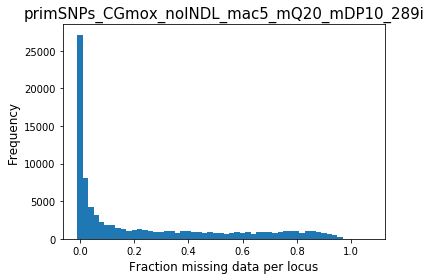

In [27]:
locus_md_file = open("out.lmiss", "r")
locus_md_dict = {}
for line in locus_md_file:
    if line.startswith("CHR") == False:
        linelist = line.strip().split()
        locus = linelist[0] + "_" + linelist[1]
        fraction_md = float(linelist[-1])
        locus_md_dict[locus] = fraction_md
locus_md_file.close()

plt.hist(locus_md_dict.values(), bins=np.arange(0,1.1,0.02) - 0.01)
plt.title("primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i", size = 15)
plt.xlabel("Fraction missing data per locus", size=12)
plt.ylabel("Frequency", size = 12)
plt.tight_layout()
plt.show()
#plt.savefig("primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.png", dpi=300)

#### Also look at MAF per locus before deciding filteirng for both MD and MAF per locus

In [28]:
!vcftools --vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.recode.vcf --freq 


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.recode.vcf
	--freq

After filtering, kept 289 out of 289 Individuals
Outputting Frequency Statistics...
After filtering, kept 87041 out of a possible 87041 Sites
Run Time = 15.00 seconds


In [29]:
ls

Filtering.ipynb*
out.frq*
out.imiss*
out.lmiss*
out.log*
primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.log*
primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.recode.vcf*
primSNPs_CGmox_noINDL_mac5_mQ20_mDP10.log*
primSNPs_CGmox_noINDL_mac5_mQ20_mDP10.recode.vcf*
primSNPs_CGmox_noINDL.vcf*
TotalRawSNPs_CGmox_noINDL.log*
TotalRawSNPs_CGmox_noINDL.recode.vcf*
TotalRawSNPs_CGmox.vcf*


In [31]:
!head out.frq

CHROM	POS	N_ALLELES	N_CHR	{ALLELE:FREQ}
dDocent_Contig_6	88	2	578	G:0.984429	A:0.0155709
dDocent_Contig_10	84	2	578	G:0.991349	A:0.00865052
dDocent_Contig_11	27	2	578	A:0.986159	C:0.0138408
dDocent_Contig_11	82	2	578	G:0.982699	C:0.017301
dDocent_Contig_12	11	2	578	T:0.987889	G:0.0121107
dDocent_Contig_13	138	2	578	G:0.991349	T:0.00865052
dDocent_Contig_26	104	2	578	C:0.953287	T:0.0467128
dDocent_Contig_29	18	2	578	G:0.991349	A:0.00865052
dDocent_Contig_29	101	2	578	C:0.989619	T:0.0103806


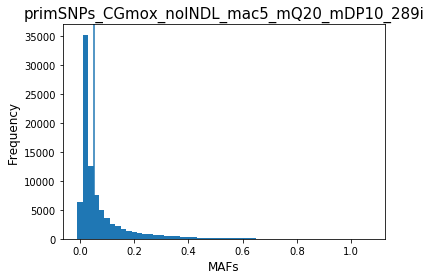

In [34]:
af_file = open("out.frq", "r")
maf_dict = {}
for line in af_file:
    if line.startswith("CHR") == False:
        linelist = line.strip().split()
        locus = linelist[0] + "_" + linelist[1]
        maf = float(linelist[-1].split(":")[1])
        maf_dict[locus] = maf
af_file.close()

plt.hist(maf_dict.values(), bins=np.arange(0,1.1,0.02) - 0.01)
plt.title("primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i", size = 15)
plt.xlabel("MAFs", size=12)
plt.ylabel("Frequency", size = 12)
plt.axvline(x=0.05)
plt.tight_layout()
plt.show()


In [35]:
!vcftools --vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.recode.vcf \
--maf 0.05 \
--max-missing 0.7 \
--recode --recode-INFO-all \
--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i.recode.vcf
	--recode-INFO-all
	--maf 0.05
	--max-missing 0.7
	--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70
	--recode

After filtering, kept 289 out of 289 Individuals
Outputting VCF file...
After filtering, kept 15003 out of a possible 87041 Sites
Run Time = 20.00 seconds


### **[6]** Convert to Genepop for last filtering steps

- convert to Genepop with PGD Spider: DONE
- add informative names using notebook (add "inam"): DONE
- manually remove reps and add "pops" (add "noreps") :DONE


### **[7]** HWE filtering

I converted the VCF to a genepop using PGD Spider so that I could use [this notebook]() to identify SNPs out of HWE.


### **[8]** One SNP per RAD tag

Pick one SNP per contig, one with highest MAF


In [57]:
# first, get positions file to feed VCF, to get MAF for just SNPs in HWE

HWE_loci = []
HWE_loci_F = open("primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70_inam_norep_HWE_loci_to_keep.txt","r")
for line in HWE_loci_F:
    if line.strip()!="":
        HWE_loci.append(line.strip())
HWE_loci_F.close()

In [58]:
HWE_loci[0:5]

['dDocent_Contig_37_91',
 'dDocent_Contig_39_52',
 'dDocent_Contig_39_80',
 'dDocent_Contig_39_97',
 'dDocent_Contig_55_22']

In [59]:
HWE_loci_positions = open("HWE_loci_to_keep_vcfpositions.txt", "w")
for locus in HWE_loci:
    locus_list = locus.split("_")
    contig = locus_list[0] + "_" + locus_list[1] + "_" + locus_list[2]
    position = locus_list[3]
    HWE_loci_positions.write(contig + "\t" + position + "\n")
HWE_loci_positions.close()

In [63]:
!head HWE_loci_to_keep_vcfpositions.txt

dDocent_Contig_37	91
dDocent_Contig_39	52
dDocent_Contig_39	80
dDocent_Contig_39	97
dDocent_Contig_55	22
dDocent_Contig_124	119
dDocent_Contig_124	129
dDocent_Contig_137	41
dDocent_Contig_137	144
dDocent_Contig_141	18


In [64]:
!vcftools --vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70.recode.vcf \
--positions HWE_loci_to_keep_vcfpositions.txt \
--recode --recode-INFO-all \
--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70_inam_norep_HWE


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70.recode.vcf
	--recode-INFO-all
	--out primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70_inam_norep_HWE
	--positions HWE_loci_to_keep_vcfpositions.txt
	--recode

After filtering, kept 289 out of 289 Individuals
Outputting VCF file...
After filtering, kept 11280 out of a possible 15003 Sites
Run Time = 14.00 seconds


In [65]:
!vcftools --vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70_inam_norep_HWE.recode.vcf --freq 


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70_inam_norep_HWE.recode.vcf
	--freq

After filtering, kept 289 out of 289 Individuals
Outputting Frequency Statistics...
After filtering, kept 11280 out of a possible 11280 Sites
Run Time = 0.00 seconds


In [66]:
!head out.frq

CHROM	POS	N_ALLELES	N_CHR	{ALLELE:FREQ}
dDocent_Contig_37	91	2	578	G:0.929066	A:0.0709343
dDocent_Contig_39	52	2	578	C:0.927336	A:0.0726644
dDocent_Contig_39	80	2	578	G:0.903114	T:0.0968858
dDocent_Contig_39	97	2	578	C:0.747405	T:0.252595
dDocent_Contig_55	22	2	578	A:0.814879	C:0.185121
dDocent_Contig_124	119	2	578	T:0.885813	G:0.114187
dDocent_Contig_124	129	2	578	T:0.944637	G:0.0553633
dDocent_Contig_137	41	2	578	C:0.821799	T:0.178201
dDocent_Contig_137	144	2	578	T:0.942907	G:0.0570934


In [67]:
af_file = open("out.frq", "r")
nested_maf_dict = {}
contig_names = []
locus_names = []
for line in af_file:
    if line.startswith("CHR") == False:
        linelist = line.strip().split()
        contig = linelist[0]
        contig_names.append(contig)
        pos = linelist[1]
        locus = contig+"_"+pos
        locus_names.append(locus)
        maf = float(linelist[-1].split(":")[1])        
        if contig not in nested_maf_dict:
            nested_maf_dict[contig] = {}
            nested_maf_dict[contig][pos] = maf
        else:
            nested_maf_dict[contig][pos] = maf
af_file.close()

In [68]:
nested_maf_dict["dDocent_Contig_39"]

{'52': 0.0726644, '80': 0.0968858, '97': 0.252595}

In [74]:
oneSNP_hiMAF_dict = {}
for contig in contig_names:
    highest_MAF = 0
    highest_MAF_pos = 0
    for pos in nested_maf_dict[contig]:
        if nested_maf_dict[contig][pos] > highest_MAF:
            highest_MAF = nested_maf_dict[contig][pos]
            highest_MAF_pos = pos
    oneSNP_hiMAF_dict[contig+"_"+highest_MAF_pos] = highest_MAF

In [75]:
len(oneSNP_hiMAF_dict.keys())

5932

In [76]:
oneSNP_hiMAF_keep = open("oneSNP_hiMAF_keepnames.txt", "w")
for locus in oneSNP_hiMAF_dict:
    oneSNP_hiMAF_keep.write(locus +"\n")
oneSNP_hiMAF_keep.close()

In [77]:
!head oneSNP_hiMAF_keepnames.txt

dDocent_Contig_37_91
dDocent_Contig_39_97
dDocent_Contig_55_22
dDocent_Contig_124_119
dDocent_Contig_137_41
dDocent_Contig_141_18
dDocent_Contig_145_66
dDocent_Contig_179_9
dDocent_Contig_211_13
dDocent_Contig_222_8


In [78]:
!python subset_GP_forloci.py \
-i primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70_inam_norep_HWE.gen \
-f 1 \
-l oneSNP_hiMAF_keepnames.txt \
-o primSNPs_CGmox_noINDL_mac5_mQ20_mDP10_289i_maf05_md70_inam_norep_HWE_oneSNPhiMAF.gen